In [1]:
import matplotlib
import glob
import pathlib
import pandas as pd
import plotly.express as px
import plotly.io as pio 
import numpy as np
import plotly.graph_objects as go

from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

pio.templates.default = "plotly_dark"
matplotlib.style.use('dark_background')

In [2]:
# use pathlib to get all the files in the data folder and concatenate them into one dataframe
path = pathlib.Path().absolute()

In [3]:

# import data in "uber-trip-data" folder and concatenate them into a pandas dataframe
path = 'uber-trip-data'
all_files = glob.glob(f"{path}/*.csv")
print(all_files)
listing_files = []
for filename in all_files:
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    listing_files.append(df_temp)
df = pd.concat(listing_files, axis=0, ignore_index=True)

['uber-trip-data/uber-raw-data-apr14.csv', 'uber-trip-data/uber-raw-data-aug14.csv', 'uber-trip-data/uber-raw-data-sep14.csv', 'uber-trip-data/uber-raw-data-jul14.csv', 'uber-trip-data/uber-raw-data-jun14.csv', 'uber-trip-data/uber-raw-data-may14.csv']


In [4]:
# Function to find missing values
def missing_values(df, norows):  # input by the df and the number of rows that you want to show
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum().sort_values(ascending=False) / df.shape[0]) * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(norows)

In [5]:
from IPython.core.display_functions import display

# Statistiques basiques
print(f"Nombre de lignes : {df.shape[0]}")
print()

print("Aperçu du dataset : ")
display(df.head())
print()

print("Statistiques basiques : ")
data_desc = df.describe(include='all', datetime_is_numeric=True)
display(data_desc)
print()

# Missing values
print("Missing values: ")
pprint(missing_values(df, 20))

Nombre de lignes : 4534327

Aperçu du dataset : 


,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512



Statistiques basiques : 


,Date/Time,Lat,Lon,Base
count,4534327,4.534327e+06,4.534327e+06,4534327
unique,260093,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02617
freq,97,NaN,NaN,1458853
mean,NaN,4.073926e+01,-7.397302e+01,NaN
std,NaN,3.994991e-02,5.726670e-02,NaN
min,NaN,3.965690e+01,-7.492900e+01,NaN
25%,NaN,4.072110e+01,-7.399650e+01,NaN
50%,NaN,4.074220e+01,-7.398340e+01,NaN
75%,NaN,4.076100e+01,-7.396530e+01,NaN



Missing values: 
           Total  Percent
Date/Time      0      0.0
Lat            0      0.0
Lon            0      0.0
Base           0      0.0


In [6]:
# Missing values
print("Missing values: ")
print(missing_values(df, 20))

Missing values: 
           Total  Percent
Date/Time      0      0.0
Lat            0      0.0
Lon            0      0.0
Base           0      0.0


In [7]:
# Splitting the date column into year, month, day and day of week as type float64
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format="%m/%d/%Y %H:%M:%S")
df['Year'] = df['Date/Time'].dt.year
df['Month'] = df['Date/Time'].dt.month
df['Day'] = df['Date/Time'].dt.day
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
df["Hour"] = df['Date/Time'].dt.hour
df.head()

,Date/Time,Lat,Lon,Base,Year,Month,Day,DayOfWeek,Hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014,4,1,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014,4,1,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014,4,1,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014,4,1,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014,4,1,1,0


In [8]:
df_sample = df[['Lat', 'Lon', "DayOfWeek", "Hour"]].sample(10000, random_state=42)

In [9]:
fig = px.scatter_mapbox(df_sample, lat="Lat", lon="Lon", animation_frame="Hour", mapbox_style="carto-positron", zoom=9, category_orders={"Hour": range(24)}, opacity=0.5, height=500, width=800)
fig.show()

In [10]:
fig = go.Figure()

for i in range(len(df_sample['DayOfWeek'].unique())):
	if i == 0:
		fig.add_trace(
			go.Histogram(
				x = df_sample[df_sample['DayOfWeek']==i]['Hour'], nbinsx = 24,
				visible = True))
	else:
		fig.add_trace(
			go.Histogram(
				x = df_sample[df_sample['DayOfWeek']==i]['Hour'], nbinsx = 24,
				visible = False))                

fig.update_layout(
    title = go.layout.Title(text = "Hourly Uber pickups per weekday" , x = 0.5),
    width = 800,
    bargap=0.1,
    bargroupgap=0.1,
    updatemenus = [
        go.layout.Updatemenu(
            active = 0,
            buttons = [
                go.layout.updatemenu.Button(
                    label = "Monday",
                    method = "update",
                    args = [{"visible" : [True, False, False, False, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Tuesday",
                    method = "update",
                    args = [{"visible" : [False, True, False, False, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Wednesday",
                    method = "update",
                    args = [{"visible" : [False, False, True, False, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Thursday",
                    method = "update",
                    args = [{"visible" : [False, False, False, True, False, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Friday",
                    method = "update",
                    args = [{"visible" : [False, False, False, False, True, False, False]}]),
                go.layout.updatemenu.Button(
                    label = "Saturday",
                    method = "update",
                    args = [{"visible" : [False, False, False, False, False, True, False]}]),
                go.layout.updatemenu.Button(
                    label = "Sunday",
                    method = "update",
                    args = [{"visible" : [False, False, False, False, False, False, True]}]),
                    ]
    )]
)

In [11]:
# Preprocessing 
scaler = StandardScaler()
X_2 = scaler.fit_transform(df_sample.loc[:, ['Lat', 'Lon']])
X_4 = scaler.fit_transform(df_sample.loc[:, ['Lat', 'Lon', 'DayOfWeek', 'Hour']])

# KMEANS
## Finding Inertia/Silhouette for 2 features

In [12]:
silhouette_scores = []
inertias = []
n_clusters = []

for n_cluster in range(2,11):
    km = KMeans(n_clusters=n_cluster)
    km.fit(X_2)
    predictions = km.predict(X_2)
    silhouette_scores.append(silhouette_score(X_2, predictions))
    inertias.append(km.inertia_)
    n_clusters.append(n_cluster)

### Create dataframe
temp_X_2 = pd.DataFrame([n_clusters, silhouette_scores, inertias]).T.rename(columns={0:"clusters", 1:"silouhette", 2:"inertia"})
temp_X_2

,clusters,silouhette,inertia
0,2.0,0.708999,14248.711123
1,3.0,0.408526,10197.056313
2,4.0,0.418297,8341.916248
3,5.0,0.417990,6989.603294
4,6.0,0.437296,5802.420941
5,7.0,0.459848,4643.462420
6,8.0,0.473522,4095.209698
7,9.0,0.475060,3572.028396
8,10.0,0.476004,3123.197006


<AxesSubplot: xlabel='clusters'>

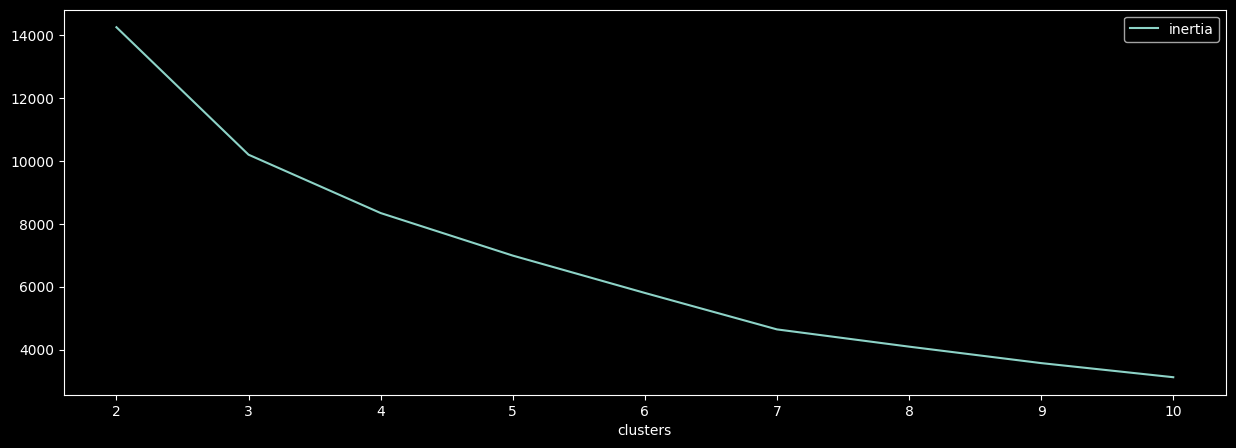

In [13]:
# Graph Inertia
temp_X_2.set_index("clusters")["inertia"].plot(figsize=(15,5), legend=True)

<AxesSubplot: xlabel='clusters'>

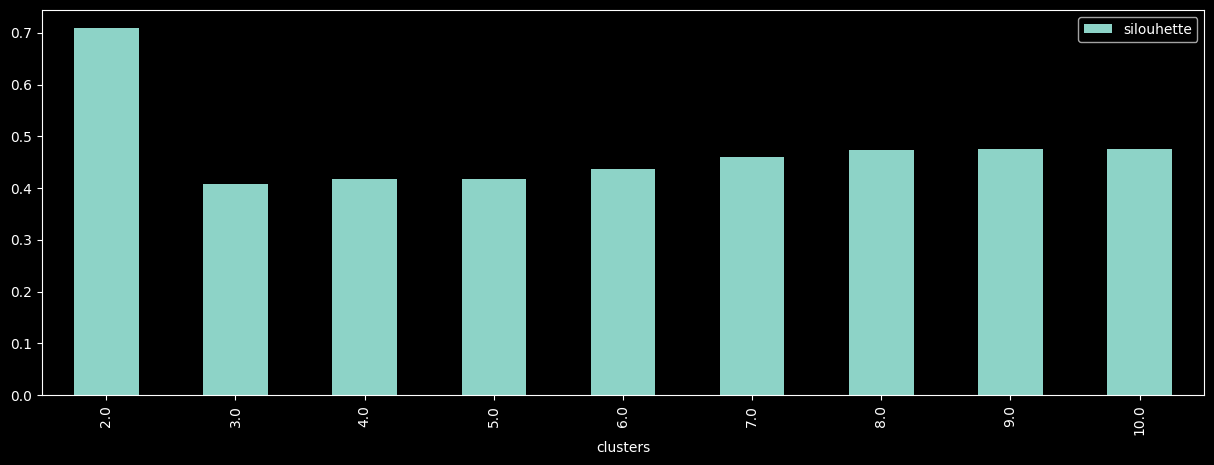

In [14]:
# Graph Silhouette
temp_X_2.set_index("clusters")["silouhette"].plot(kind='bar', figsize=(15,5), legend=True)

In [15]:
km = KMeans(n_clusters=4, random_state=0) # 7 clusters
km.fit(X_2)
predictions = km.predict(X_2)

In [16]:
df_sample.loc[:,'Cluster_KMeans_X_2'] = predictions
df_sample.head()

,Lat,Lon,DayOfWeek,Hour,Cluster_KMeans_X_2
255777,40.7588,-73.9726,3,20,0
2591794,40.7806,-73.9582,4,17,0
1384006,40.7399,-73.9823,3,22,0
530592,40.6449,-73.7824,0,16,1
3679163,40.7708,-73.8656,6,9,2


In [17]:
fig = px.scatter_mapbox(df_sample, lat="Lat", lon="Lon", color="Cluster_KMeans_X_2", mapbox_style="carto-positron", zoom=10, height=500, width=800)
fig.show()

## Finding Optimal Clusters with Inertia/Silhouette for 4 features

In [18]:
silhouette_scores = []
inertias = []
n_clusters = []

for n_cluster in range(2,11):
    km = KMeans(n_clusters=n_cluster)
    km.fit(X_4)
    predictions = km.predict(X_4)
    silhouette_scores.append(silhouette_score(X_4, predictions))
    inertias.append(km.inertia_)
    n_clusters.append(n_cluster)

### Create dataframe
temp_X_4 = pd.DataFrame([n_clusters, silhouette_scores, inertias]).T.rename(columns={0:"clusters", 1:"silouhette", 2:"inertia"})
temp_X_4

,clusters,silouhette,inertia
0,2.0,0.224068,32616.275262
1,3.0,0.257873,27478.000162
2,4.0,0.262621,22413.934148
3,5.0,0.268197,20016.370489
4,6.0,0.253250,17946.425085
5,7.0,0.238911,16483.458797
6,8.0,0.264053,15437.101955
7,9.0,0.220065,14538.797262
8,10.0,0.245813,13395.014511


<AxesSubplot: xlabel='clusters'>

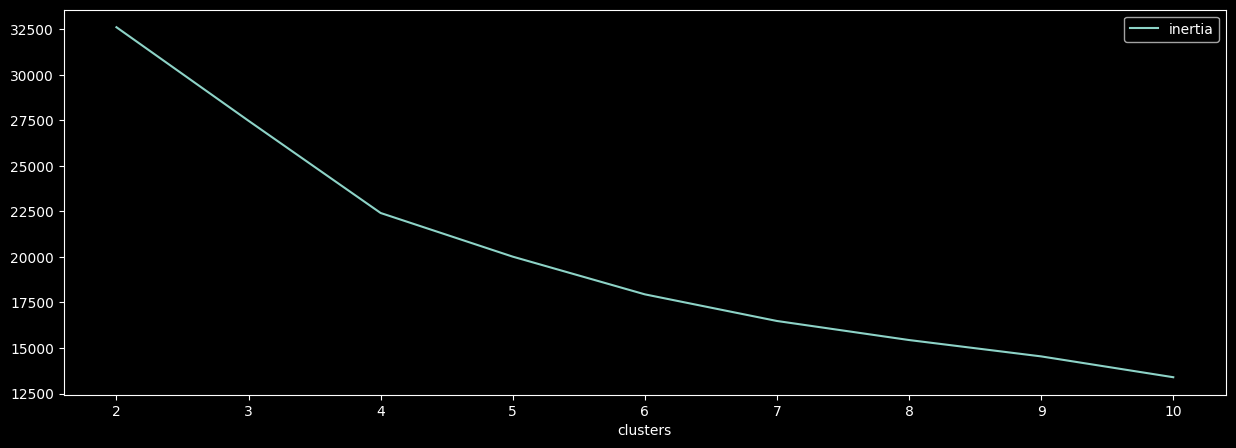

In [19]:
# Graph Inertia
temp_X_4.set_index("clusters")["inertia"].plot(figsize=(15,5), legend=True)

<AxesSubplot: xlabel='clusters'>

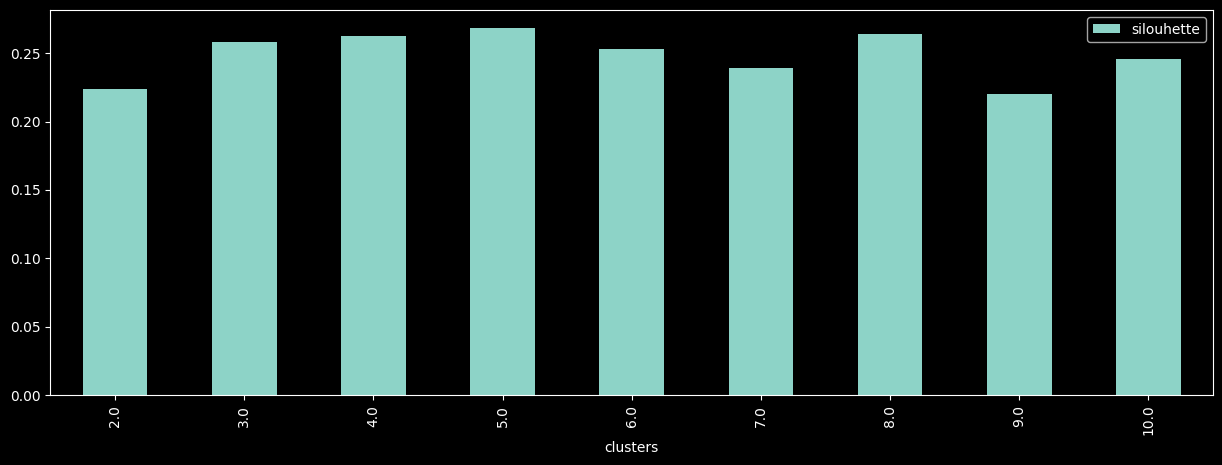

In [20]:
# Graph Silhouette
temp_X_4.set_index("clusters")["silouhette"].plot(kind='bar', figsize=(15,5), legend=True)

In [21]:
km = KMeans(n_clusters=4, random_state=0)
km.fit(X_4)
predictions = km.predict(X_4)

df_sample.loc[:,'Cluster_KMeans_X_4'] = predictions
df_sample.head()

,Lat,Lon,DayOfWeek,Hour,Cluster_KMeans_X_2,Cluster_KMeans_X_4
255777,40.7588,-73.9726,3,20,0,1
2591794,40.7806,-73.9582,4,17,0,1
1384006,40.7399,-73.9823,3,22,0,1
530592,40.6449,-73.7824,0,16,1,2
3679163,40.7708,-73.8656,6,9,2,0


In [22]:
fig = px.scatter_mapbox(df_sample, lat="Lat", lon="Lon", color="Cluster_KMeans_X_4", mapbox_style="carto-positron", zoom=10, height=500, width=800)
fig.show()

# DBSCAN
## 2 Features

In [23]:
# Instanciate DBSCAN 
db_2 = DBSCAN(eps=0.11, min_samples=50, metric="manhattan", n_jobs=-1, algorithm="brute").fit(X_2) 
labels = db_2.labels_
df_sample["DBSCAN_Cluster_X_2"] = labels

In [24]:
# for each db_4.labels_ value, create a dictionary with the corresponding cluster centroid longitude and latitude
centroid_dict = {i: [df_sample[df_sample["DBSCAN_Cluster_X_2"] == i]["Lon"].mean(), df_sample[df_sample["DBSCAN_Cluster_X_2"] == i]["Lat"].mean()] for i in df_sample["DBSCAN_Cluster_X_2"].unique()}
# create two columns latitude and longitude for the corresponding cluster centroid
df_sample["DBSCAN_Cluster_X_2_Lat"] = df_sample["DBSCAN_Cluster_X_2"].map(lambda x: centroid_dict[x][1])
df_sample["DBSCAN_Cluster_X_2_Lon"] = df_sample["DBSCAN_Cluster_X_2"].map(lambda x: centroid_dict[x][0])

In [25]:
# Map of clusters centroids
fig = px.scatter_mapbox(df_sample[df_sample["DBSCAN_Cluster_X_2"] != -1], lat="DBSCAN_Cluster_X_2_Lat", lon="DBSCAN_Cluster_X_2_Lon", color="DBSCAN_Cluster_X_2", zoom=8, mapbox_style="carto-positron", animation_frame="Hour", category_orders={"Hour": range(24)}, height=500, width=800)
fig.show()

In [26]:
fig = px.scatter_mapbox(df_sample[df_sample["DBSCAN_Cluster_X_2"] != -1], lat="Lat", lon="Lon", color="DBSCAN_Cluster_X_2", zoom=8, mapbox_style="carto-positron", animation_frame="Hour", category_orders={"Hour": range(24)}, height=500, width=800)
fig.show()

## 4 Features


In [27]:
# Instanciate DBSCAN 
db_4 = DBSCAN(eps=0.11, min_samples=10, metric="manhattan", n_jobs=-1, algorithm="brute").fit(X_4) 
labels = db_4.labels_
df_sample["DBSCAN_Cluster_X_4"] = labels

In [29]:
# for each db_4.labels_ value, create a dictionary with the corresponding cluster centroid longitude and latitude
centroid_dict = {i: [df_sample[df_sample["DBSCAN_Cluster_X_4"] == i]["Lon"].mean(), df_sample[df_sample["DBSCAN_Cluster_X_4"] == i]["Lat"].mean()] for i in df_sample["DBSCAN_Cluster_X_4"].unique()}
# create two columns latitude and longitude for the corresponding cluster centroid
df_sample["DBSCAN_Cluster_X_4_Lat"] = df_sample["DBSCAN_Cluster_X_4"].map(lambda x: centroid_dict[x][1])
df_sample["DBSCAN_Cluster_X_4_Lon"] = df_sample["DBSCAN_Cluster_X_4"].map(lambda x: centroid_dict[x][0])


In [30]:
fig = px.scatter_mapbox(df_sample[df_sample["DBSCAN_Cluster_X_4"] != -1], lat="DBSCAN_Cluster_X_4_Lat", lon="DBSCAN_Cluster_X_4_Lon", color="DBSCAN_Cluster_X_4", zoom=8, mapbox_style="carto-positron", animation_frame="Hour", category_orders={"Hour": range(24)}, height=500, width=800)
fig.show()

In [31]:
fig = px.scatter_mapbox(df_sample[df_sample["DBSCAN_Cluster_X_4"] != -1], lat="Lat", lon="Lon", color="DBSCAN_Cluster_X_4", zoom=8, mapbox_style="carto-positron", animation_frame="Hour", category_orders={"Hour": range(24)}, opacity=0.5, height=500, width=800)
fig.show()